In [1]:
import os
import pandas as pd
from collections import defaultdict
import numpy as np
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
from Bio import SeqIO

sns.set(font_scale=1.8, style="ticks")
month="02"

# Reading vaccine effectiveness

In [2]:
subtype_time2vaccine_strains = dict()
subtype_time2ve = dict()

for subtype in ("h3n2", "h1n1"):
    ve_path = "../../data/vaccine_effectiveness/ve_%s.csv" % subtype
    ve = pd.read_csv(ve_path)
    ve["time_bin"] = [int(year.split("-")[0]) - 2018 + 30 for year in ve["Year"]]
    ve["vaccine effectiveness"] = [x if isinstance(x, float) else float(x[:-1]) for x in ve["VE"].to_numpy()]
    ve["subtype"] = [subtype] * len(ve)
    print(ve)

    time2vaccine_strains = dict()
    time2ve = dict()

    for strains, year, eff in zip(ve["Strain"], ve["Year"], ve["vaccine effectiveness"]):
        if isinstance(eff, float) and np.isnan(eff):
            continue
        
        year = int(year.split("-")[0]) # 2018
        time2vaccine_strains[year] = strains.split("|")
        time2ve[year] = eff
    subtype_time2vaccine_strains[subtype] = time2vaccine_strains
    subtype_time2ve[subtype] = time2ve


         Year   VE    95% CI                                     Strain  \
0   2011-2012  39%   (23 52)                            A/Perth/16/2009   
1   2012-2013  39%   (29 47)                        A/Victoria/361/2011   
2   2013-2014  NaN       NaN                            A/Texas/50/2012   
3   2014-2015   6%   (-5 17)                            A/Texas/50/2012   
4   2015-2016  NaN       NaN                 A/Switzerland/9715293/2013   
5   2016-2017  33%   (23 41)                      A/Hong Kong/4801/2014   
6   2017-2018  22%   (12 31)                      A/Hong Kong/4801/2014   
7   2018-2019   9%   (-4 20)            A/Singapore/INFIMH-16-0019/2016   
8   2019-2020  NaN       NaN                           A/Kansas/14/2017   
9   2020-2021  NaN       NaN  A/Hong Kong/2671/2019|A/Hong Kong/45/2019   
10  2021-2022  36%   (21 48)                   A/Cambodia/e0826360/2020   
11  2022-2023  NaN       NaN            A/Darwin/9/2021|A/Darwin/6/2021   
12  2023-2024  30%       

In [3]:
models_results = defaultdict(list)

In [4]:
threshold=0.4

all_models = set()

res = defaultdict(list)

for year in range(2012, 2022):
    if year in (2021, 2022, 2020):
        continue
    print(year)
    
    subtype2ave_scores = defaultdict(dict)
    subtype2ranking = defaultdict(dict)
    
    for subtype in ("h3n2", "h1n1"):
        if year not in subtype_time2ve[subtype]:
            continue

        virus_seq_path="../../data/gisaid/ha_processed/%d-%s_to_%d-%s_9999M/a_%s/human_minBinSize1000_lenQuantile0.2_minCnt5.fasta" % (year-3, month, year, month,subtype)
        virus_id2seq = dict()
        for record in SeqIO.parse(virus_seq_path, "fasta"):
            virus_id2seq[record.id] = str(record.seq)
            
        
        ##### Our vaccine + HI model
        who_score_path = "../../runs/pipeline/%d-%s/a_%s/vaccine_set=who___virus_set=%d-%s-%d-%s/vaccine_scores" % (year, month, subtype, year-3, month, year, month)
        all_score_path = "../../runs/pipeline/%d-%s/a_%s/vaccine_set=%d-%s-%d-%s___virus_set=%d-%s-%d-%s/vaccine_scores" % (year, month, subtype, year-3, month, year, month, year-3, month, year, month)

        for root, dirs, files in os.walk(who_score_path, topdown=False):
            for name in files:
                if name == "vaccine_score_and_gt.csv":
                    model_name = os.path.join(root, name).split("vaccine_scores")[1].split("vaccine_score_and_gt.csv")[0].strip("/")        
                    if model_name != "prob=weight_loss_by_count_lightning_logs_version_0___hi=max_steps_150k":
                        continue
                    
                    df = pd.read_csv(os.path.join(root, name))

                    # prediction
                    ave_score = -np.median(df["score"])
                    model_name = "Escapability score (prediction)"
                    subtype2ave_scores[subtype][model_name] = ave_score
                    all_models.add(model_name)
                    
                    # ground-truth
                    ave_score = -np.median(df[df["coverage_seq"] > threshold]["gt_score_seq"])                    
                    model_name = "Escapability score"
                    subtype2ave_scores[subtype][model_name] = ave_score
                    all_models.add(model_name)
        

        ##### Dominance only
        vaccine_seq_path = "../../data/recommended_vaccines_from_gisaid_ha/%d-%d_NH_a_%s.fasta" % (year, year + 1, subtype)
        vaccine_seqs = set([str(record.seq) for record in SeqIO.parse(vaccine_seq_path, "fasta")])

        # How many months
        history_month = 6
        max_history_index=(( (year - 2003) * 6 + (2 - 10) // 2 - 1 ))
        min_history_index=( max_history_index - history_month // 2 + 1 )
        seq2freq = defaultdict(int)
        for index in range(min_history_index, max_history_index+1):
            path = "/data/rbg/users/wxsh/vaxseer/data/gisaid/ha_processed/2003-10_to_2023-04_2M/a_%s/human_minBinSize100_lenQuantile0.2_bins/%d.fasta" % (subtype, index)
            
            if not os.path.exists(path):
                continue
            for record in SeqIO.parse(path, "fasta"):
                description = record.description.split()[1].split("|")
                description = {x.split("=")[0]: x.split("=")[1] for x in description}
                count = round(float(description["freq"]) * float(description["bin_size"]))
                seq2freq[str(record.seq)] += count

        seq2freq = {k: v / sum(seq2freq.values()) for k, v in seq2freq.items()}
        vaccine_seq_freq = sum([seq2freq.get(s, 0) for s in vaccine_seqs])
        subtype2ave_scores[subtype]["Last(%dM)" % history_month] = vaccine_seq_freq
        all_models.add("Last(%dM)" % history_month)
            
        # HI exp only
        if year <= 2021:
            hi_exp_path = "../../data/antigenicity/hi_processed/before_%d-02/a_%s_hi_folds.csv" % (year, subtype)
            hi_seq_path = "../../data/antigenicity/hi_processed/before_%d-02/a_%s.fasta" % (year, subtype)
        else:
            hi_exp_path = "../../data/antigenicity/hi_processed_2024_2025_merge/before_%d-02/a_%s_hi_folds.csv" % (year, subtype)
            hi_seq_path = "../../data/antigenicity/hi_processed_2024_2025_merge/before_%d-02/a_%s.fasta" % (year, subtype)
        id2seq = {record.id: str(record.seq) for record in SeqIO.parse(hi_seq_path, "fasta")}
        df = pd.read_csv(hi_exp_path)
        vaccine_seq2his = defaultdict(list)
        for virus, reference, hi in zip(df["virus"], df["reference"], df["hi"]):
            vaccine_seq2his[id2seq[reference]].append((id2seq[virus], hi))        
        vaccine_seq2hi_median = {x: -np.median([y[1] for y in vaccine_seq2his[x]]) for x in vaccine_seq2his}
        
        candidate_vaccine_path="../../data/recommended_vaccines_from_gisaid_ha/%d-%d_NH_a_%s.fasta" % (year, year + 1, subtype)
        all_hi_values = []
        for record in SeqIO.parse(candidate_vaccine_path, "fasta"):
            hi_values = vaccine_seq2his[str(record.seq)]
            hi_values = np.asarray([x[1] for x in hi_values])
            if len(hi_values) > 0:
                all_hi_values.append(hi_values)
        all_hi_values = -np.concatenate(all_hi_values)
        median_hi_values = np.mean(all_hi_values) # median / mean        
        subtype2ave_scores[subtype]["HI median"] = median_hi_values
        all_models.add("HI median")
        
        for model_name in subtype2ave_scores[subtype]:
            res["year"].append(year)
            res["model"].append(model_name)
            res["score"].append(subtype2ave_scores[subtype][model_name])

            res["ve"].append(subtype_time2ve[subtype][year])
            res["subtype"].append(("a/"+subtype).upper())
            


2012
2013
2014
2015
2016
2017
2018
2019


In [5]:
res = pd.DataFrame(res)
res.to_csv("fig4_ve.csv", index=False)

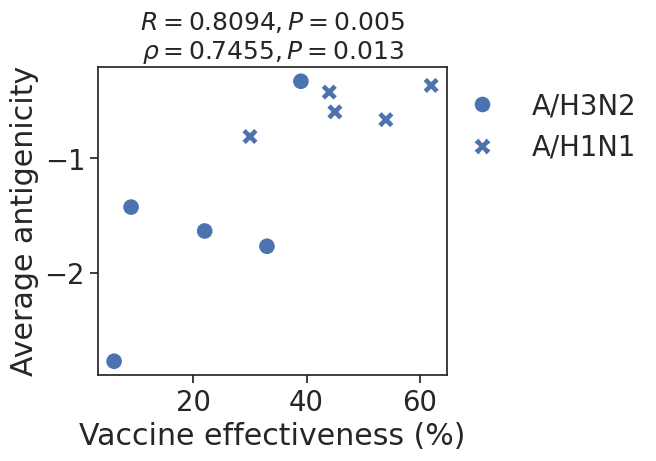

In [6]:
fig, ax = plt.subplots(figsize=(4.5, 4))

ax = sns.scatterplot(y = "score", x = "ve",# , "x"
           data = res[res["model"].isin(["HI median"])], style="subtype", s=150, ax=ax) # ci = 95) # , ci=95
ax.legend(frameon=False)
legend = ax.get_legend()
spearman_rank, spearman_rank_p = stats.spearmanr(res[res["model"].isin(["HI median"])]["score"], res[res["model"].isin(["HI median"])]["ve"])
pearsonr, pearson_p = stats.pearsonr(res[res["model"].isin(["HI median"])]["score"], res[res["model"].isin(["HI median"])]["ve"])

ax.set_title(f"$R=%.4lf, P=%.3lf$\n$\\rho=%.4lf, P=%.3lf$" % (pearsonr, pearson_p, spearman_rank, spearman_rank_p), fontsize=18)

ax.set_ylabel("Average antigenicity")
ax.set_xlabel("Vaccine effectiveness (%)")
sns.move_legend(ax, "upper left", bbox_to_anchor=(0.95, 1))
plt.savefig("figs/ve_overall_hi_median.pdf", format='pdf', bbox_inches='tight')


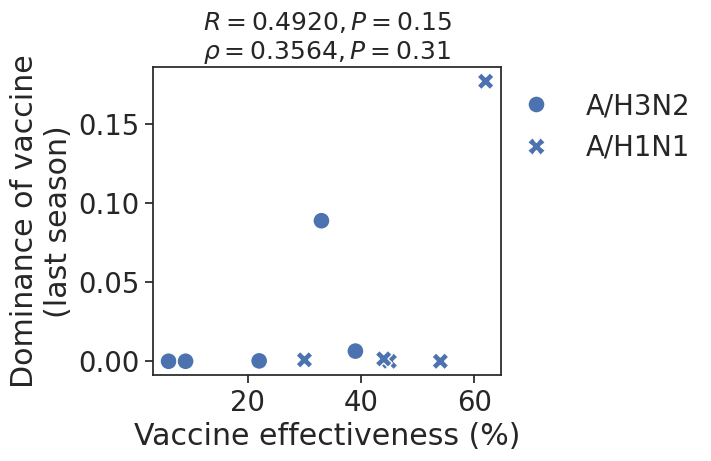

In [7]:
fig, ax = plt.subplots(figsize=(4.5, 4))

ax = sns.scatterplot(y = "score", x = "ve",# , "x"
           data = res[res["model"].isin(["Last(6M)"])], style="subtype", s=150, ax=ax) # ci = 95) # , ci=95

ax.legend(frameon=False)

legend = ax.get_legend()
spearman_rank, spearman_rank_p = stats.spearmanr(res[res["model"].isin(["Last(6M)"])]["score"], res[res["model"].isin(["Last(6M)"])]["ve"])
pearsonr, pearson_p = stats.pearsonr(res[res["model"].isin(["Last(6M)"])]["score"], res[res["model"].isin(["Last(6M)"])]["ve"])

ax.set_title(f"$R=%.4lf, P=%.2lf$\n$\\rho=%.4lf, P=%.2lf$" % (pearsonr, pearson_p, spearman_rank, spearman_rank_p), fontsize=18)

ax.set_ylabel("Dominance of vaccine\n(last season)")
ax.set_xlabel("Vaccine effectiveness (%)")

sns.move_legend(ax, "upper left", bbox_to_anchor=(0.95, 1))

plt.savefig("figs/ve_overall_vaccine_dominance_6M.pdf", format='pdf', bbox_inches='tight')


In [8]:
_res = res[res["model"] == "Escapability score (prediction)"]
gt = _res["ve"]
modelA = _res["score"]
_res = res[res["model"] == "HI median"]
modelB = _res["score"]

In [10]:
from scipy.stats import bootstrap
from scipy.stats import spearmanr
def my_statistic(gt, modelA, modelB): # gt, 
    r1, _ = spearmanr(modelA, gt)
    r2, _ = spearmanr(modelB, gt)
    return r1-r2

rng = np.random.default_rng()
data = (modelA.to_numpy(), modelB.to_numpy()) # gt.to_numpy(), 
bootstrap_res = bootstrap((gt, modelA, modelB), my_statistic, vectorized=False, paired=True,
                random_state=rng,n_resamples=100000)
print(my_statistic(gt, modelA, modelB))
print(bootstrap_res.confidence_interval)

0.1454545454545455
ConfidenceInterval(low=0.0, high=0.5490196078431373)


In [11]:
models_results = defaultdict(list)

for model in list(set(res["model"])):
    print(model)
    _res = res[res["model"] == model]
    pred_spearman_rank, pred_pvalue = stats.spearmanr(_res["score"], _res["ve"])
    pred_pearsonr, pred_pvalue_pearson = stats.pearsonr(_res["score"], _res["ve"])

    models_results["model"].append(model)
    models_results["Pearson"].append(pred_pearsonr)
    models_results["Pearson P"].append(pred_pvalue_pearson)

    models_results["Spearman rank"].append(pred_spearman_rank)
    models_results["Spearman rank P"].append(pred_pvalue)
    
models_results = pd.DataFrame(models_results)
print(models_results)

Escapability score (prediction)
HI median
Last(6M)
Escapability score
                             model   Pearson  Pearson P  Spearman rank  \
0  Escapability score (prediction)  0.861125   0.001372       0.890909   
1                        HI median  0.809439   0.004552       0.745455   
2                         Last(6M)  0.492049   0.148568       0.356424   
3               Escapability score  0.895186   0.000464       0.975758   

   Spearman rank P  
0         0.000542  
1         0.013330  
2         0.312050  
3         0.000001  


/tmp/ipykernel_3243681/3346971247.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(_models_results,
/tmp/ipykernel_3243681/3346971247.py:21: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(_models_results,


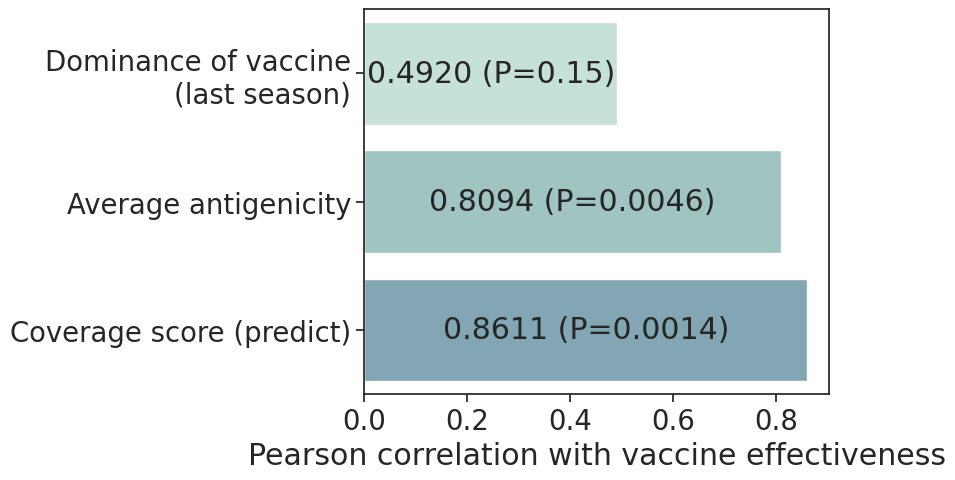

In [12]:
model_list_1 = [
                "Last(6M)", 
                 "HI median", 
                "Escapability score (prediction)" , 
               ]

_models_results = models_results[models_results["model"].isin(model_list_1)]
_models_results = _models_results.set_index('model', drop=False)
_models_results = _models_results.reindex(model_list_1)

_models_results.loc['Last(6M)','model'] = 'Dominance of vaccine\n(last season)'

_models_results.loc['Escapability score (prediction)','model'] = 'Coverage score (predict)'
_models_results.loc["HI median",'model'] = 'Average antigenicity'

_models_results[""] = _models_results["model"]

fig, ax = plt.subplots()
fig.set_size_inches(6, 5)

ax = sns.barplot(_models_results, 
                 x="Pearson", y="", orient="h", palette=sns.cubehelix_palette(start=.5, rot=-.5, dark=.5, n_colors=4),
                 ax=ax
                )

display_labels = []
for value, p in zip(_models_results["Pearson"], _models_results["Pearson P"]):
    display_labels.append("%.4f (P=%.2g)" % (value, p))

for i, container in enumerate(ax.containers):
    ax.bar_label(container, labels=[display_labels[i]], label_type="center")

ax.set_xlabel("Pearson correlation with vaccine effectiveness")
plt.savefig("figs/pearson_ve_all_models.pdf", format='pdf', bbox_inches='tight')

plt.show()

/tmp/ipykernel_3243681/1738857895.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(_models_results,
/tmp/ipykernel_3243681/1738857895.py:22: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(_models_results,


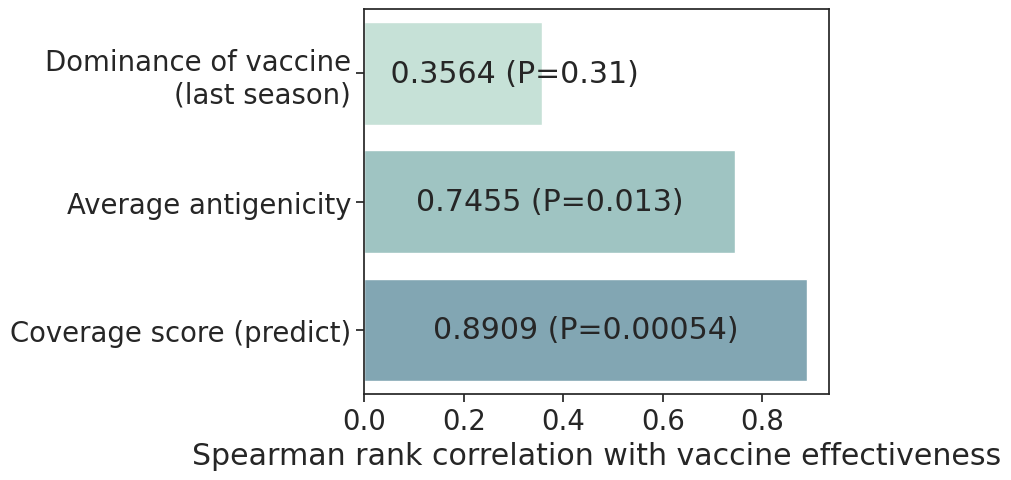

In [13]:
model_list_1 = [
                "Last(6M)", 
                 "HI median", 
                "Escapability score (prediction)" , 
   
               ]

_models_results = models_results[models_results["model"].isin(model_list_1)]
_models_results = _models_results.set_index('model', drop=False)
_models_results = _models_results.reindex(model_list_1)

_models_results.loc['Last(6M)','model'] = 'Dominance of vaccine\n(last season)'
_models_results.loc['Escapability score (prediction)','model'] = 'Coverage score (predict)'
_models_results.loc["HI median",'model'] = 'Average antigenicity'

_models_results[""] = _models_results["model"]

fig, ax = plt.subplots()
fig.set_size_inches(6, 5)
# fig.set_tight_layout(True)

ax = sns.barplot(_models_results, 
                 x="Spearman rank", y="", orient="h", palette=sns.cubehelix_palette(start=.5, rot=-.5, dark=.5, n_colors=4),
                 ax=ax
                )

display_labels = []
for value, p in zip(_models_results["Spearman rank"], _models_results["Spearman rank P"]):
    display_labels.append("%.4f (P=%.2g)" % (value, p))
display_labels[0] =  "             " + display_labels[0]

for i, container in enumerate(ax.containers):
    ax.bar_label(container, labels=[display_labels[i]], label_type="center")
    
ax.set_xlabel("Spearman rank correlation with vaccine effectiveness")
plt.savefig("figs/spearman_ve_all_models.pdf", format='pdf', bbox_inches='tight') # 
plt.show()

2.268692426445239 0.026499240881812592


/tmp/ipykernel_3243681/836497979.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=res[res['model'] == 'Escapability score (prediction)'],


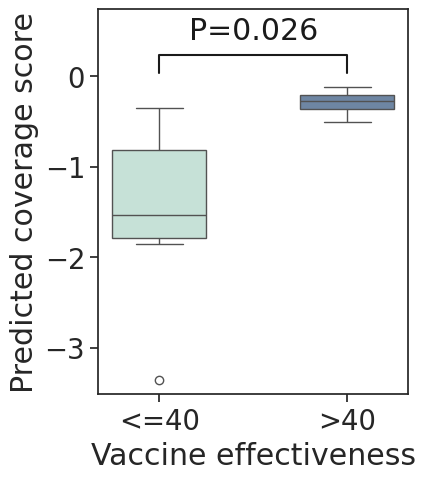

In [15]:
res["Vaccine effectiveness"] = [">40" if x > 40 else "<=40" for x in res["ve"]]

fig, ax = plt.subplots()
fig.set_size_inches(4, 5)

ax = sns.boxplot(data=res[res['model'] == 'Escapability score (prediction)'], 
            x="Vaccine effectiveness", y="score", ax=ax,
                 palette=sns.cubehelix_palette(start=.5, rot=-.5, dark=.5, n_colors=2), width=0.5)
ax.set_ylabel("Predicted coverage score")

_res = res[res['model'] == 'Escapability score (prediction)']

t_statistic, p_value = stats.ttest_ind(_res[_res["Vaccine effectiveness"] == ">40"]["score"], 
                                       _res[_res["Vaccine effectiveness"] == "<=40"]["score"], alternative='greater')

print(t_statistic, p_value)

# Define a function to annotate the plot
def annotate_significance(ax, x1, x2, y, p_value):
    if p_value < 0.001:
        label = '***'
    elif p_value < 0.01:
        label = '**'
    elif p_value < 0.05:
        label = '*'
    else:
        label = 'ns'  # not significant
    label="P=%.2g" % p_value

    ax.plot([x1, x1, x2, x2], [y, y + 0.2, y + 0.2, y], lw=1.5, c='k')
    ax.text((x1 + x2) * 0.5, y + 0.3, label, ha='center', va='bottom', color='k')

# Set y-limit higher to accommodate the annotation
ylim = ax.get_ylim()
ax.set_ylim([ylim[0], ylim[1] + 0.7])

# Add annotation
annotate_significance(ax, 0, 1, ylim[1], p_value)

plt.savefig("figs/ve_pred_boxplot_with_pvalue.pdf", format='pdf', bbox_inches='tight')

plt.show()

>40 4
-0.36769059519303304
<=40 6
-1.9770633177963939
2.9017015473383947 0.00991993714428878


/tmp/ipykernel_3243681/3834073474.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=res[res['model'] == 'Escapability score'],


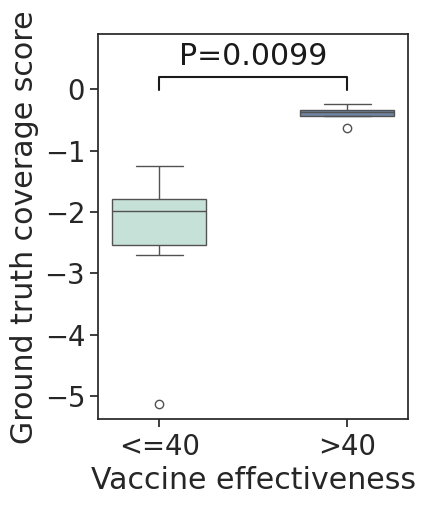

In [17]:
res["Vaccine effectiveness"] = [">40" if x > 40 else "<=40" for x in res["ve"]]

fig, ax = plt.subplots()
fig.set_size_inches(4, 5)

ax = sns.boxplot(data=res[res['model'] == 'Escapability score'], 
            x="Vaccine effectiveness", y="score", ax=ax,
                 palette=sns.cubehelix_palette(start=.5, rot=-.5, dark=.5, n_colors=2), width=0.5)
ax.set_ylabel("Ground truth coverage score")

_res = res[res['model'] == 'Escapability score']


print(">40", len(_res[_res["Vaccine effectiveness"] == ">40"]["score"]))
print(np.median(_res[_res["Vaccine effectiveness"] == ">40"]["score"]))
print("<=40", len(_res[_res["Vaccine effectiveness"] == "<=40"]["score"]))
print(np.median(_res[_res["Vaccine effectiveness"] == "<=40"]["score"]))

t_statistic, p_value = stats.ttest_ind(_res[_res["Vaccine effectiveness"] == ">40"]["score"], 
                                       _res[_res["Vaccine effectiveness"] == "<=40"]["score"], alternative='greater')

print(t_statistic, p_value)

# Define a function to annotate the plot
def annotate_significance(ax, x1, x2, y, p_value):
    if p_value < 0.001:
        label = '***'
    elif p_value < 0.01:
        label = '**'
    elif p_value < 0.05:
        label = '*'
    else:
        label = 'ns'  # not significant

    label="P=%.2g" % p_value

    ax.plot([x1, x1, x2, x2], [y, y + 0.2, y + 0.2, y], lw=1.5, c='k')
    ax.text((x1 + x2) * 0.5, y + 0.3, label, ha='center', va='bottom', color='k')

# Set y-limit higher to accommodate the annotation
ylim = ax.get_ylim()
ax.set_ylim([ylim[0], ylim[1] + 0.9])

# Add annotation
annotate_significance(ax, 0, 1, ylim[1], p_value)

plt.savefig("figs/ve_gt_boxplot_with_pvalue.pdf", format='pdf', bbox_inches='tight')

plt.show()